# Capstone Project - The Battle of the Neighborhoods 
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#Methodology)
* [Analysis](#Analysis)
* [Results and Discussion](#Results)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction: Business Problem <a name="introduction"></a>

This project will focus on finding an optimal location for opening a new **French** restaurant in **Cologne, Germany**. 

Cologne is located in the state of North-Rhine Westphalia and is the fourth-most populous city in Germany [1]. It is also the largest city on the Rhine river, split into 9 districts and is most famous for its world heritage cathedral, as well as the carnival festivals which are attracting millions of tourists every year. In addition, the city of Cologne has a unique mixture of people with various cultural backgrounds and this contributes to a very rich gastronomy environment. Due to its proximity to neighboring countries of France, Belgium and the Netherlands, the French cuisine can be particularly popular among tourists and locals. 

The main goal of the project is to analyze how saturated each of the 9 districts are with regards to French restaurants and to support stakeholders who want to find the optimal district in Cologne for opening a new French restaurant.

## Data <a name="data"></a>

Given the nature of our business problem, we will consider the following factors for our analysis and decision:
- number of existing French restaurants in each of the 9 districts of Cologne
- population in each of the 9 districts
- average housing price within each district

The data will be obtained from the following sources:
- To find information about the different districts in Cologne, data will be scraped from Wikipedia [2]
- Geopy geocoders library is used to find the geolocation for each of the districts
- Foursquare API is used to obtain the most common venues around each district and in particular the French restaurants
- To find data about housing prices, I used a report created by immobilienscout24, a leading real estate company for the german market [3]. It breaks down the housing price for each neighborhood in Cologne for the year 2019. This data was used to generate the average housing price for the 9 districts of Cologne.


### Extracting Districts of Cologne

Lets first import the libraries we need for our analysis

In [1]:
#Import all libraries
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
  
!pip -q install folium
import folium # import folium for visualization

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Folium and geopy installed')
print('Libraries imported.')

Folium and geopy installed
Libraries imported.


Let's now scrape the data from Wikipedia and create a dataframe out of it

In [2]:
# Transform data from Wikipedia url into a pd df
url = 'https://en.wikipedia.org/wiki/Districts_of_Cologne'
html = requests.get(url).content
df_list = pd.read_html(html)
df_wiki = df_list[1]
df_wiki.head()

,Map,Coat,City district,City parts,Area,Population1,Pop. density,District Councils,Town Hall
0,NaN,NaN,District 1 Köln-Innenstadt,"Altstadt-Nord, Altstadt-Süd, Deutz, Neustadt-N...",16.4 km²,127.033,7.746/km²,"Bezirksksamt Innenstadt Brückenstraße 19, D-50...",NaN
1,NaN,NaN,District 2 Köln-Rodenkirchen,"Bayenthal, Godorf, Hahnwald, Immendorf, Marien...",54.6 km²,100.936,1.850/km²,"Bezirksamt Rodenkirchen Hauptstraße 85, D-5099...",NaN
2,NaN,NaN,District 3 Köln-Lindenthal,"Braunsfeld, Junkersdorf, Klettenberg, Lindenth...",41.6 km²,137.552,3.308/km²,"Bezirksamt Lindenthal Aachener Straße 220, 509...",NaN
3,NaN,NaN,District 4 Köln-Ehrenfeld,"Bickendorf, Bocklemünd/Mengenich, Ehrenfeld, N...",23.8 km²,103.621,4.348/km²,"Bezirksamt Ehrenfeld Venloer Straße 419 – 421,...",NaN
4,NaN,NaN,District 5 Köln-Nippes,"Bilderstöckchen, Longerich, Mauenheim, Niehl, ...",31.8 km²,110.092,3.462/km²,"Bezirksamt NippesNeusser Straße 450,D-50733 Köln",NaN


We need to tranform the table for our analysis by dropping unnecessary columns and rows, as well as renaming columns:

In [3]:
df_wiki.drop(['Map', 'Coat', 'City parts', 'Area', 'Pop. density', 'District Councils', 'Town Hall'], axis=1,inplace=True)
df_wiki.drop([9, 10],axis=0,inplace=True)
df_wiki.rename(columns={'Population1': 'Population'}, inplace=True)
df_wiki

,City district,Population
0,District 1 Köln-Innenstadt,127.033
1,District 2 Köln-Rodenkirchen,100.936
2,District 3 Köln-Lindenthal,137.552
3,District 4 Köln-Ehrenfeld,103.621
4,District 5 Köln-Nippes,110.092
5,District 6 Köln-Chorweiler,80.870
6,District 7 Köln-Porz,106.520
7,District 8 Köln-Kalk,108.330
8,District 9 Köln-Mülheim,144.374


Looking great! Now we have the data for the 9 districts and the population in each.

Now lets transform the values for the population into a float, so that we can analyze it later on:

In [4]:
df_wiki['Population'] = df_wiki.Population.astype(float)
df_wiki.dtypes

City district     object
Population       float64
dtype: object

## Extracting Data for Housing Prices

A report I found from immobilienscout24 [3] includes a very up-to-date information for the average housing price in EUR/m2 in each neighborhood of Cologne and it dates from the year of 2019. The data includes the corresponding district for each neighborhood. I then calculated the average housing price for each district and can now input it into a dictionary so that we can further process it: 

In [5]:
housing_cgn = {'City district': ['District 1 Köln-Innenstadt', 'District 2 Köln-Rodenkirchen', 'District 3 Köln-Lindenthal','District 4 Köln-Ehrenfeld', 'District 5 Köln-Nippes', 'District 6 Köln-Chorweiler','District 7 Köln-Porz', 'District 8 Köln-Kalk', 'District 9 Köln-Mülheim' ], 
              'Avg_House_Price': [6730.66, 4768.76, 5527.44, 4741.66, 4887.85, 3497.58, 3327.06, 3511.33, 3895.11]}

Let's convert the dictionary into a dataframe:

In [6]:
df_housing_cgn=pd.DataFrame.from_dict(housing_cgn)
df_housing_cgn

,City district,Avg_House_Price
0,District 1 Köln-Innenstadt,6730.66
1,District 2 Köln-Rodenkirchen,4768.76
2,District 3 Köln-Lindenthal,5527.44
3,District 4 Köln-Ehrenfeld,4741.66
4,District 5 Köln-Nippes,4887.85
5,District 6 Köln-Chorweiler,3497.58
6,District 7 Köln-Porz,3327.06
7,District 8 Köln-Kalk,3511.33
8,District 9 Köln-Mülheim,3895.11


## Geolocation for each district

By using the geopy.geocoders library that was inported earlier, I can now find the latitude and longitude of each district:

In [7]:
address = 'Innenstadt, Cologne'

geolocator = Nominatim(user_agent="cologne_explorer")
location = geolocator.geocode(address)
latitude_d1 = location.latitude
longitude_d1 = location.longitude
print('The geograpical coordinates of Innenstadt are {}, {}.'.format(latitude_d1, longitude_d1))

The geograpical coordinates of Innenstadt are 50.93732845, 6.959234323073302.


In [8]:
address = 'Rodenkirchen, Cologne'

geolocator = Nominatim(user_agent="cologne_explorer")
location = geolocator.geocode(address)
latitude_d2 = location.latitude
longitude_d2 = location.longitude
print('The geograpical coordinates of Rodenkirchen are {}, {}.'.format(latitude_d2, longitude_d2))

The geograpical coordinates of Rodenkirchen are 50.87875, 6.981804397809072.


In [9]:
address = 'Lindenthal, Cologne'

geolocator = Nominatim(user_agent="cologne_explorer")
location = geolocator.geocode(address)
latitude_d3 = location.latitude
longitude_d3 = location.longitude
print('The geograpical coordinates of Lindenthal are {}, {}.'.format(latitude_d3, longitude_d3))

The geograpical coordinates of Lindenthal are 50.9359354, 6.871246459161802.


In [10]:
address = 'Ehrenfeld, Cologne'

geolocator = Nominatim(user_agent="cologne_explorer")
location = geolocator.geocode(address)
latitude_d4 = location.latitude
longitude_d4 = location.longitude
print('The geograpical coordinates of Ehrenfeld are {}, {}.'.format(latitude_d4, longitude_d4))

The geograpical coordinates of Ehrenfeld are 50.9679925, 6.887914431752257.


In [11]:
address = 'Nippes, Cologne'

geolocator = Nominatim(user_agent="cologne_explorer")
location = geolocator.geocode(address)
latitude_d5 = location.latitude
longitude_d5 = location.longitude
print('The geograpical coordinates of Nippes are {}, {}.'.format(latitude_d5, longitude_d5))

The geograpical coordinates of Nippes are 50.98864895, 6.935727475616647.


In [12]:
address = 'Chorweiler, Cologne'

geolocator = Nominatim(user_agent="cologne_explorer")
location = geolocator.geocode(address)
latitude_d6 = location.latitude
longitude_d6 = location.longitude
print('The geograpical coordinates of Chorweiler are {}, {}.'.format(latitude_d6, longitude_d6))

The geograpical coordinates of Chorweiler are 51.03537, 6.892049121238911.


In [13]:
address = 'Porz, Cologne'

geolocator = Nominatim(user_agent="cologne_explorer")
location = geolocator.geocode(address)
latitude_d7 = location.latitude
longitude_d7 = location.longitude
print('The geograpical coordinates of Porz are {}, {}.'.format(latitude_d7, longitude_d7))

The geograpical coordinates of Porz are 50.8799229, 7.0950744704864315.


In [14]:
address = 'Kalk, Cologne'

geolocator = Nominatim(user_agent="cologne_explorer")
location = geolocator.geocode(address)
latitude_d8 = location.latitude
longitude_d8 = location.longitude
print('The geograpical coordinates of Kalk are {}, {}.'.format(latitude_d8, longitude_d8))

The geograpical coordinates of Kalk are 50.93596865, 7.066924990481073.


In [15]:
address = 'Mülheim, Cologne'

geolocator = Nominatim(user_agent="cologne_explorer")
location = geolocator.geocode(address)
latitude_d9 = location.latitude
longitude_d9 = location.longitude
print('The geograpical coordinates of Mülheim are {}, {}.'.format(latitude_d9, longitude_d9))

The geograpical coordinates of Mülheim are 50.9614907, 7.0063139.


Let's put all coordinates into a dictionaty, which we will then tranform into a dataframe:

In [16]:
geoloc_cgn = {'City district': ['District 1 Köln-Innenstadt', 'District 2 Köln-Rodenkirchen', 'District 3 Köln-Lindenthal','District 4 Köln-Ehrenfeld', 'District 5 Köln-Nippes', 'District 6 Köln-Chorweiler','District 7 Köln-Porz', 'District 8 Köln-Kalk', 'District 9 Köln-Mülheim' ], 
              'Latitude': [50.93732845, 50.87875, 50.9359354, 50.9679925, 50.98864895, 51.03537, 50.8799229, 50.93596865, 50.9614907], 
              'Longitude': [6.959234323073302, 6.981804397809072, 6.871246459161802, 6.887914431752257, 6.935727475616647, 6.892049121238911, 7.0950744704864315, 7.066924990481073, 7.0063139]}

In [17]:
df_geoloc_cgn=pd.DataFrame.from_dict(geoloc_cgn)
df_geoloc_cgn

,City district,Latitude,Longitude
0,District 1 Köln-Innenstadt,50.937328,6.959234
1,District 2 Köln-Rodenkirchen,50.878750,6.981804
2,District 3 Köln-Lindenthal,50.935935,6.871246
3,District 4 Köln-Ehrenfeld,50.967993,6.887914
4,District 5 Köln-Nippes,50.988649,6.935727
5,District 6 Köln-Chorweiler,51.035370,6.892049
6,District 7 Köln-Porz,50.879923,7.095074
7,District 8 Köln-Kalk,50.935969,7.066925
8,District 9 Köln-Mülheim,50.961491,7.006314


Now lets merge all datasets into one, resulting into one table with the districs, their coordinates as well as the population & average house price per district:

In [18]:
df_cgn_interim = pd.merge(left=df_wiki, right=df_housing_cgn, how='left', left_on='City district', right_on='City district')
df_cgn = pd.merge(left=df_cgn_interim, right=df_geoloc_cgn, how='left', left_on='City district', right_on='City district')
df_cgn

,City district,Population,Avg_House_Price,Latitude,Longitude
0,District 1 Köln-Innenstadt,127.033,6730.66,50.937328,6.959234
1,District 2 Köln-Rodenkirchen,100.936,4768.76,50.878750,6.981804
2,District 3 Köln-Lindenthal,137.552,5527.44,50.935935,6.871246
3,District 4 Köln-Ehrenfeld,103.621,4741.66,50.967993,6.887914
4,District 5 Köln-Nippes,110.092,4887.85,50.988649,6.935727
5,District 6 Köln-Chorweiler,80.870,3497.58,51.035370,6.892049
6,District 7 Köln-Porz,106.520,3327.06,50.879923,7.095074
7,District 8 Köln-Kalk,108.330,3511.33,50.935969,7.066925
8,District 9 Köln-Mülheim,144.374,3895.11,50.961491,7.006314


### Visualizing districts in Cologne

Let's visualize the 9 districts. First we need to obtain the coordinates for Cologne:

In [19]:
# Get geolocation of Cologne
address = 'Cologne, Germany'

geolocator = Nominatim(user_agent="cologne_explorer")
location = geolocator.geocode(address)
latitude_cgn = location.latitude
longitude_cgn = location.longitude
print('The geograpical coordinates of Cologne are {}, {}.'.format(latitude_cgn, longitude_cgn))

The geograpical coordinates of Cologne are 50.938361, 6.959974.


Now let's use folium for the visualization:

In [20]:
# Visualize districts of Cologne using latitude and longitude values
map_cgn = folium.Map(location=[latitude_cgn, longitude_cgn], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_cgn['Latitude'], df_cgn['Longitude'], df_cgn['City district']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cgn)  
    
map_cgn

### Obtain data from Foursquare API

Now we will use Foursquare API in order to see the venues for each of the districts and in particular focus on the French restaurants.

Credentials for login are inputted below:

In [21]:
# Connect to Foursquare
CLIENT_ID = 'HATTM2CLO0JKU5RVSDEXSVRTMROCI3OHIJYQBFJ1EREQR5MV' 
CLIENT_SECRET = 'DCT20P5OPCP4U14NPJ1SIPCCOE5FVTACNQMEIMSFEHZ04SXC' 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HATTM2CLO0JKU5RVSDEXSVRTMROCI3OHIJYQBFJ1EREQR5MV
CLIENT_SECRET:DCT20P5OPCP4U14NPJ1SIPCCOE5FVTACNQMEIMSFEHZ04SXC


In [22]:
#Create request url
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 8000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_cgn, 
    longitude_cgn, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=HATTM2CLO0JKU5RVSDEXSVRTMROCI3OHIJYQBFJ1EREQR5MV&client_secret=DCT20P5OPCP4U14NPJ1SIPCCOE5FVTACNQMEIMSFEHZ04SXC&v=20180605&ll=50.938361,6.959974&radius=8000&limit=100'

In [23]:
#Get the results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fcf949a2aa0530e5a6cca93'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Cologne',
  'headerFullLocation': 'Cologne',
  'headerLocationGranularity': 'city',
  'totalResults': 236,
  'suggestedBounds': {'ne': {'lat': 51.01036107200007,
    'lng': 7.074018189303187},
   'sw': {'lat': 50.86636092799993, 'lng': 6.845929810696813}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '57fa333d498e66b44a75a041',
       'name': 'Craftbeer Corner',
       'location': {'address': 'Martinstr. 32',
        'crossStreet': 'Marsplatz',
        'lat': 50.93722182832159,
        'lng': 6.958927666244598,
        'labeledLatLngs': [{'label': 'display',
          

In [24]:
#Define function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [25]:
#Create df from the foursquare data about the venues
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Craftbeer Corner,Beer Bar,50.937222,6.958928
1,Rheinufer Altstadt,Pedestrian Plaza,50.938827,6.962870
2,Papa Joe's Jazzlokal,Jazz Club,50.937882,6.962241
3,LEGO Store,Toy / Game Store,50.937042,6.956564
4,Sattgrün,Vegetarian / Vegan Restaurant,50.938441,6.954965


### Explore nearby Venues around Cologne Districts

In [26]:
#Create a function with a radius of 6000m 
def getNearbyVenues(names, latitudes, longitudes, radius=6000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City district', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
#Run function and create new df
cgn_venues = getNearbyVenues(names=df_cgn['City district'],
                                   latitudes=df_cgn['Latitude'],
                                   longitudes=df_cgn['Longitude']
                                  )

District 1 Köln-Innenstadt
District 2 Köln-Rodenkirchen
District 3 Köln-Lindenthal
District 4 Köln-Ehrenfeld
District 5 Köln-Nippes
District 6 Köln-Chorweiler
District 7 Köln-Porz
District 8 Köln-Kalk
District 9 Köln-Mülheim


In [28]:
#Check size of new df
print(cgn_venues.shape)
cgn_venues.head()

(852, 7)


,City district,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,District 1 Köln-Innenstadt,50.937328,6.959234,Craftbeer Corner,50.937222,6.958928,Beer Bar
1,District 1 Köln-Innenstadt,50.937328,6.959234,LEGO Store,50.937042,6.956564,Toy / Game Store
2,District 1 Köln-Innenstadt,50.937328,6.959234,Papa Joe's Jazzlokal,50.937882,6.962241,Jazz Club
3,District 1 Köln-Innenstadt,50.937328,6.959234,Sattgrün,50.938441,6.954965,Vegetarian / Vegan Restaurant
4,District 1 Köln-Innenstadt,50.937328,6.959234,Rheinufer Altstadt,50.938827,6.962870,Pedestrian Plaza


In [29]:
#Check how many venues there are for each neighbourhood
cgn_venues.groupby('City district').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City district,,,,,,
District 1 Köln-Innenstadt,100,100,100,100,100,100
District 2 Köln-Rodenkirchen,100,100,100,100,100,100
District 3 Köln-Lindenthal,100,100,100,100,100,100
District 4 Köln-Ehrenfeld,100,100,100,100,100,100
District 5 Köln-Nippes,100,100,100,100,100,100
District 6 Köln-Chorweiler,52,52,52,52,52,52
District 7 Köln-Porz,100,100,100,100,100,100
District 8 Köln-Kalk,100,100,100,100,100,100
District 9 Köln-Mülheim,100,100,100,100,100,100


In [30]:
print('There are {} uniques categories.'.format(len(cgn_venues['Venue Category'].unique())))

There are 162 uniques categories.


In [31]:
# check venues categories and no of avaliable venues
print (cgn_venues['Venue Category'].value_counts())

Café                  62
Italian Restaurant    44
Park                  43
Supermarket           42
Hotel                 34
                      ..
Castle                 1
Fish Market            1
Food & Drink Shop      1
Candy Store            1
Art Gallery            1
Name: Venue Category, Length: 162, dtype: int64


We see that there are 161 unique categories. We are now interested into the **French restaurants**.

### Analyze each district of Cologne

In [32]:
# one hot encoding
cgn_onehot = pd.get_dummies(cgn_venues[['Venue Category']], prefix="", prefix_sep="")

# add District column back to dataframe
cgn_onehot['City district'] = cgn_venues['City district'] 

# move District column to the first column
fixed_columns = [cgn_onehot.columns[-1]] + list(cgn_onehot.columns[:-1])
cgn_onehot = cgn_onehot[fixed_columns]

cgn_onehot.head()

,City district,Airport,Airport Lounge,Airport Service,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Austrian Restaurant,...,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Yoga Studio,Zoo,Zoo Exhibit
0,District 1 Köln-Innenstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,District 1 Köln-Innenstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,District 1 Köln-Innenstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,District 1 Köln-Innenstadt,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,District 1 Köln-Innenstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#Group by District by taking the mean of the frequency of occurrence of each category
cgn_grouped = cgn_onehot.groupby('City district').mean().reset_index()
cgn_grouped

,City district,Airport,Airport Lounge,Airport Service,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Austrian Restaurant,...,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Yoga Studio,Zoo,Zoo Exhibit
0,District 1 Köln-Innenstadt,0.00,0.00,0.00,0.000000,0.00,0.03,0.00,0.00,0.00,...,0.00,0.00,0.01,0.02,0.000000,0.00,0.00,0.01,0.00,0.00
1,District 2 Köln-Rodenkirchen,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.00,0.00,0.010000,0.01,0.00,0.00,0.00,0.00
2,District 3 Köln-Lindenthal,0.00,0.00,0.00,0.000000,0.00,0.00,0.01,0.00,0.00,...,0.01,0.00,0.00,0.01,0.000000,0.00,0.00,0.01,0.01,0.00
3,District 4 Köln-Ehrenfeld,0.00,0.00,0.00,0.000000,0.00,0.00,0.01,0.00,0.00,...,0.00,0.00,0.00,0.01,0.000000,0.00,0.01,0.00,0.01,0.00
4,District 5 Köln-Nippes,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.01,0.01,0.000000,0.01,0.01,0.00,0.01,0.01
5,District 6 Köln-Chorweiler,0.00,0.00,0.00,0.019231,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.019231,0.00,0.00,0.00,0.00,0.00
6,District 7 Köln-Porz,0.02,0.01,0.02,0.000000,0.00,0.00,0.00,0.01,0.00,...,0.00,0.03,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00
7,District 8 Köln-Kalk,0.00,0.00,0.00,0.020000,0.01,0.00,0.00,0.02,0.00,...,0.00,0.06,0.01,0.00,0.000000,0.01,0.00,0.00,0.00,0.00
8,District 9 Köln-Mülheim,0.00,0.00,0.00,0.000000,0.00,0.03,0.00,0.01,0.01,...,0.00,0.01,0.01,0.01,0.000000,0.01,0.01,0.00,0.01,0.03


### Explore Relationship between Districts and French Restaurants


In [34]:
# Extract French Restaurant column from grouped df
cgn_french_rest = cgn_grouped[['City district', 'French Restaurant']]
cgn_french_rest.head()

,City district,French Restaurant
0,District 1 Köln-Innenstadt,0.01
1,District 2 Köln-Rodenkirchen,0.03
2,District 3 Köln-Lindenthal,0.01
3,District 4 Köln-Ehrenfeld,0.01
4,District 5 Köln-Nippes,0.02


In [35]:
# merge dataframe with district of Cologne with dataframe with french restaurants
cgn_french_all = pd.merge(df_cgn, cgn_french_rest, on='City district')
cgn_french_all.head()

,City district,Population,Avg_House_Price,Latitude,Longitude,French Restaurant
0,District 1 Köln-Innenstadt,127.033,6730.66,50.937328,6.959234,0.01
1,District 2 Köln-Rodenkirchen,100.936,4768.76,50.878750,6.981804,0.03
2,District 3 Köln-Lindenthal,137.552,5527.44,50.935935,6.871246,0.01
3,District 4 Köln-Ehrenfeld,103.621,4741.66,50.967993,6.887914,0.01
4,District 5 Köln-Nippes,110.092,4887.85,50.988649,6.935727,0.02


Amazing - now we have our data collected from all sources and it contains information about the population, average housing price, geolocation and distribution of French restaurants in each of the districs of Cologne. We can now proceed further.

## Methodology <a name="Methodology"></a>

The aim of the project is to find an optimal location for establishing a French restaurant within each of the 9 districts in the city of Cologne. To enable this the following steps were carried out:

Firstly, the data used for the analysis was collected from publicly available sources. The obtained information comprises of the names, geolocation, population & average housing price for each of the districts in Cologne. Fourspace API is utilized to find restaurants in a radius of 6000m from the coordinates of each district. Folium is then used to visualize the data, where barchart and histograms will be used to analyze the distribution of the number of restaurants, population & average housing price.  

Next step performed is to cluster the districts with an unsupervised learning K-means algorithm. The elbow method is to be utilized to obtain the optimum value for K.

Finally, based on the obtained clusters, outcomes can be discussed and a conclusion can be drawn.

## Analysis <a name="Analysis"></a>

Now that we have our data collected, we can now perform some analysis. First let's look at the distribution of the french restaurants across the different districts.

### Visualize Nr of French Restaurants in Cologne Districts

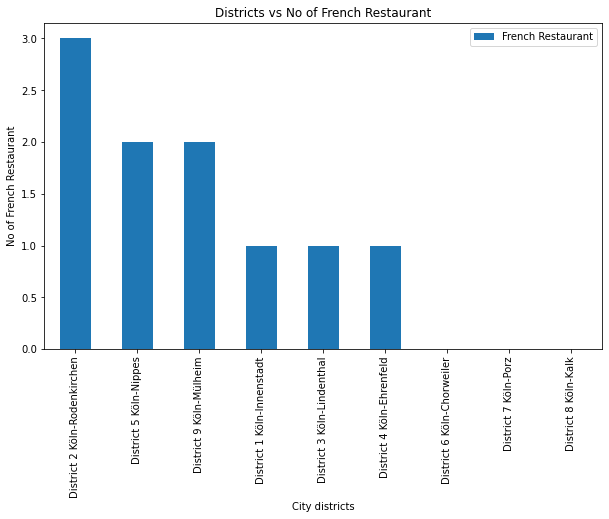

In [36]:
graph = pd.DataFrame(cgn_onehot.groupby('City district')['French Restaurant'].sum())
graph = graph.sort_values(by ='French Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("City districts")
plt.ylabel("No of French Restaurant")
plt.title("Districts vs No of French Restaurant")
plt.show()

We easily see that District 2 Köln-Rodenkichen has the highest concentration of French restaurants - 3. This is followed by district 5 & 9 with 2 respectively. District 1, 3 and 4 have 1 french restaurant. Finally, District 6, 7 and 8 do not have any restaurants in the radius determined above. 

We can then group the Districts in the following manner:
1. Value 3: High concentration of French restaurants
2. Value 2: Mid concentration of French restaurants
3. Value 1: Low concentration of French restaurants
4. Value 0: No concentration of French restaurants

### Visualize Population data in Cologne Districts

Now let's take a look at the distribution of population in each district. We will use a barchart & histrogram for this:

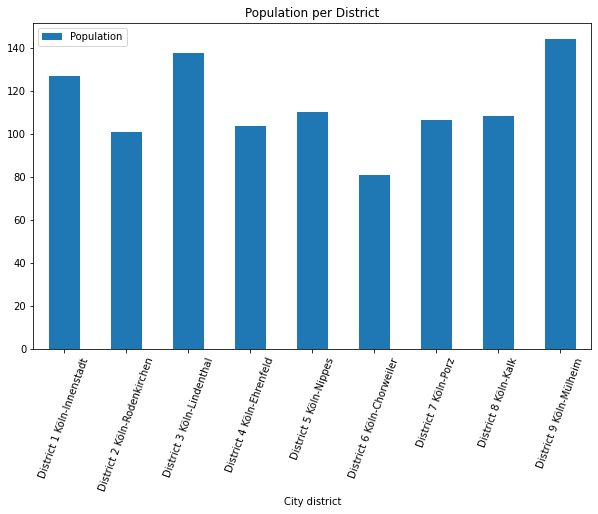

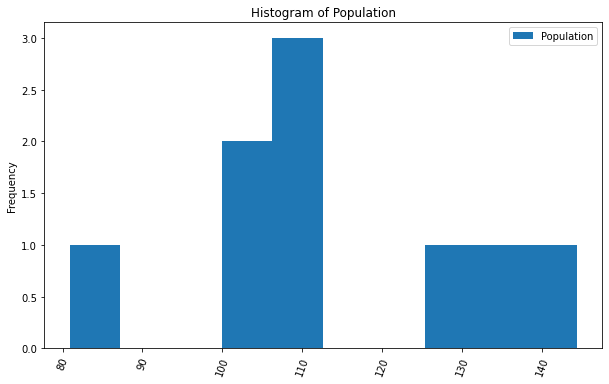

In [37]:
cgn_french_all.plot.bar(x='City district', y='Population',rot=70, title="Population per District", figsize=(10,6))
plt.show(block=True)

cgn_french_all.plot.hist(x='City district', y='Population',rot=70, title="Histogram of Population", figsize=(10,6))
plt.show(block=True)

The barchart shows us that district 9 Köln-Mülheim is the most populous area, whereas district 6 Köln-Chorweiler is the least populous.

Based on the histogram we can define the following ranges for the distribution of the population per district:
1. Up to 100k people = "Low Population District"
2. Between 100k and 125k people = "Mid Population District"
3. Above 125k people = "High Population District"

### Visualize Housing price data in Cologne Districts

Let's continue the analysis for the housing prices:

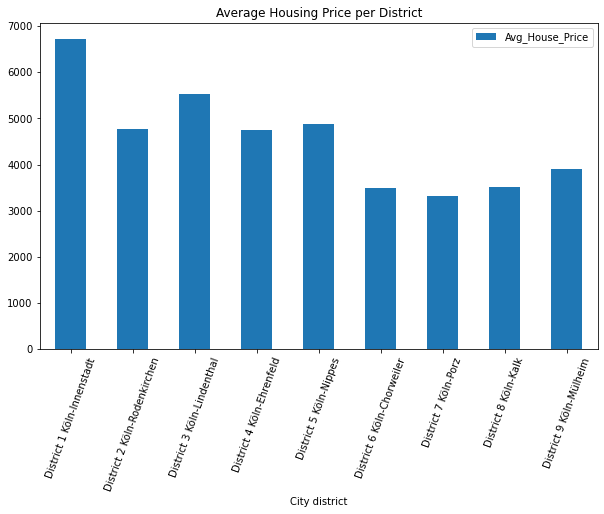

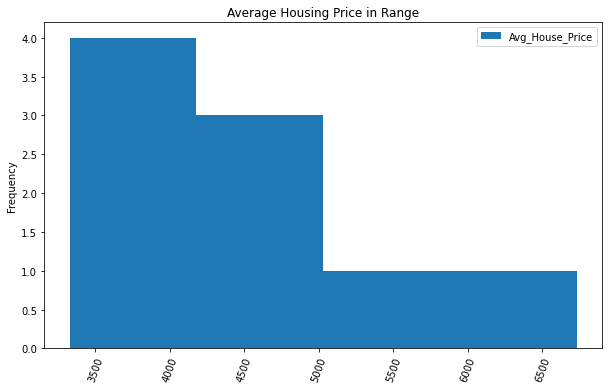

In [38]:
cgn_french_all.plot.bar(x='City district', y='Avg_House_Price',rot=70, title="Average Housing Price per District", figsize=(10,6))
plt.show(block=True)

cgn_french_all.plot.hist(x='City district', y='Avg_House_Price',rot=70, title="Average Housing Price in Range", figsize=(10,6), bins=4)
plt.show(block=True)

Housing prices are the highest in district 1 Köln-Innenstadt, whereas in district 7 Köln-Porz the average housing prices are the lowest.

Based on the histogram we can define the following ranges for the distribution of the average housing price per district:
1. Up to 4000 EUR/m2 = "Low Average Housing Price"
2. Between 4000 and 5000 EUR/m2 = "Mid Average Housing Price"
3. Above 5000 EUR/m2 = "High Average Housing Price"

### K-means Clustering 

Now that we have an idea of the data after analyzing it, lets use unsupervized machine learning algorith K-means clustering to group the data.

First lets standardize the data:

In [39]:
from sklearn.preprocessing import StandardScaler 

cgn_french_rest_clustering = cgn_french_all.drop('City district', 1)
cgn_french_rest_clustering = cgn_french_rest_clustering.drop('Latitude', 1)
cgn_french_rest_clustering = cgn_french_rest_clustering.drop('Longitude', 1)
cgn_french_rest_clustering = cgn_french_rest_clustering.values
cgn_french_rest_clustering = StandardScaler().fit_transform(cgn_french_rest_clustering)
cgn_french_rest_clustering

array([[ 0.73961669,  2.07329227, -0.1118034 ],
       [-0.66166904,  0.21391509,  1.90065778],
       [ 1.30443734,  0.93294882, -0.1118034 ],
       [-0.51749721,  0.18823126, -0.1118034 ],
       [-0.17003505,  0.32678182,  0.89442719],
       [-1.73911854, -0.99083697, -1.11803399],
       [-0.3618346 , -1.15244612, -1.11803399],
       [-0.26464614, -0.9778055 , -1.11803399],
       [ 1.67074655, -0.61408066,  0.89442719]])

We will use the elbow method to determine the best value for K. We will use 2 methods:

In [40]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt 


distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(cgn_french_rest_clustering) 
    kmeanModel.fit(cgn_french_rest_clustering)     
      
    distortions.append(sum(np.min(cdist(cgn_french_rest_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / cgn_french_rest_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(cgn_french_rest_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / cgn_french_rest_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

1 : 1.644910488791428
2 : 1.1321999581829465
3 : 0.8603384034848242
4 : 0.6137680808625103
5 : 0.474080778261986
6 : 0.2828813475867172
7 : 0.14148594093092168
8 : 0.022206923160947942
9 : 0.0


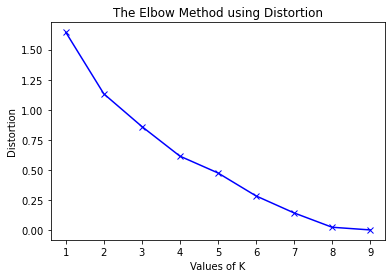

In [41]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val))
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

1 : 26.999999999999993
2 : 13.706373020512952
3 : 8.275615493677288
4 : 4.352378254143336
5 : 2.7649866058539123
6 : 1.4058883478620516
7 : 0.5961855764160611
8 : 0.019972471169187975
9 : 0.0


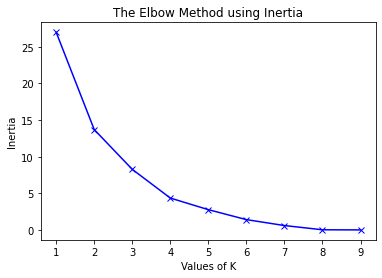

In [42]:
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

Based on the elbow methods applied above, the optimum value for K is **4**. Let's proceed further with fitting the model:

In [43]:
clusters =4
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(cgn_french_rest_clustering)

kmeans.labels_

array([2, 0, 2, 0, 0, 1, 1, 1, 3], dtype=int32)

Now let's add the labels to our dataframe:

In [44]:
cgn_french_rest.insert(0, 'Cluster Labels', kmeans.labels_)
cgn_french_rest.head()

,Cluster Labels,City district,French Restaurant
0,2,District 1 Köln-Innenstadt,0.01
1,0,District 2 Köln-Rodenkirchen,0.03
2,2,District 3 Köln-Lindenthal,0.01
3,0,District 4 Köln-Ehrenfeld,0.01
4,0,District 5 Köln-Nippes,0.02


In [45]:
df_cgn2 = df_cgn
df_cgn2.head()

,City district,Population,Avg_House_Price,Latitude,Longitude
0,District 1 Köln-Innenstadt,127.033,6730.66,50.937328,6.959234
1,District 2 Köln-Rodenkirchen,100.936,4768.76,50.878750,6.981804
2,District 3 Köln-Lindenthal,137.552,5527.44,50.935935,6.871246
3,District 4 Köln-Ehrenfeld,103.621,4741.66,50.967993,6.887914
4,District 5 Köln-Nippes,110.092,4887.85,50.988649,6.935727


In [46]:
df_cgn2 = df_cgn2.join(cgn_french_rest.set_index('City district'), on='City district')
df_cgn2.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
df_cgn2.reset_index(drop=True, inplace=True)
df_cgn2['Cluster Labels'].astype(int)
df_cgn2.head()

,City district,Population,Avg_House_Price,Latitude,Longitude,Cluster Labels,French Restaurant
0,District 1 Köln-Innenstadt,127.033,6730.66,50.937328,6.959234,2,0.01
1,District 2 Köln-Rodenkirchen,100.936,4768.76,50.878750,6.981804,0,0.03
2,District 3 Köln-Lindenthal,137.552,5527.44,50.935935,6.871246,2,0.01
3,District 4 Köln-Ehrenfeld,103.621,4741.66,50.967993,6.887914,0,0.01
4,District 5 Köln-Nippes,110.092,4887.85,50.988649,6.935727,0,0.02


Great! Now we have our table with all information and the predicted labels. 

Next, lets visualize the different clusters:

In [47]:
clusters_map = folium.Map(location=[latitude_cgn, longitude_cgn], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cgn2['Latitude'],
                                  df_cgn2['Longitude'],
                                  df_cgn2['City district'],
                                  df_cgn2['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(clusters_map)
clusters_map

### Analyze Clusters

Last step, let's have a look at each one of the 4 clusters:

#### Cluster 0: Mid population, mid-high average housing price & mixed concentration of French restaurants:

In [48]:
cluster_0 = df_cgn2.loc[df_cgn2['Cluster Labels'] == 0]
cluster_0.head()

,City district,Population,Avg_House_Price,Latitude,Longitude,Cluster Labels,French Restaurant
1,District 2 Köln-Rodenkirchen,100.936,4768.76,50.878750,6.981804,0,0.03
3,District 4 Köln-Ehrenfeld,103.621,4741.66,50.967993,6.887914,0,0.01
4,District 5 Köln-Nippes,110.092,4887.85,50.988649,6.935727,0,0.02


#### Cluster 1: Low population, low average housing price & no concentration of French restaurants:

In [49]:
cluster_1 = df_cgn2.loc[df_cgn2['Cluster Labels'] == 1]
cluster_1.head()

,City district,Population,Avg_House_Price,Latitude,Longitude,Cluster Labels,French Restaurant
5,District 6 Köln-Chorweiler,80.87,3497.58,51.035370,6.892049,1,0.0
6,District 7 Köln-Porz,106.52,3327.06,50.879923,7.095074,1,0.0
7,District 8 Köln-Kalk,108.33,3511.33,50.935969,7.066925,1,0.0


#### Cluster 2: High population, high average housing price & low concentratino of French restaurants:

In [50]:
cluster_2 = df_cgn2.loc[df_cgn2['Cluster Labels'] == 2]
cluster_2.head()

,City district,Population,Avg_House_Price,Latitude,Longitude,Cluster Labels,French Restaurant
0,District 1 Köln-Innenstadt,127.033,6730.66,50.937328,6.959234,2,0.01
2,District 3 Köln-Lindenthal,137.552,5527.44,50.935935,6.871246,2,0.01


#### Cluster 3: High population, low average housing price & mid concentration of French restaurants:

In [51]:
cluster_3 = df_cgn2.loc[df_cgn2['Cluster Labels'] == 3]
cluster_3.head()

,City district,Population,Avg_House_Price,Latitude,Longitude,Cluster Labels,French Restaurant
8,District 9 Köln-Mülheim,144.374,3895.11,50.961491,7.006314,3,0.02


## Results & Discussion <a name="Results"></a>

The analysis shows that our collected data is suitable to be grouped into 4 clusters. If we examine the Cluster 0 we see that a mid-size population & mid to high average housing prices entails having a mixed environment for a French restaurant. Each of the 3 districts in the clusters have a different concentration - from low to high. This represents an interesting outlook for any stakeholder who might be willing to open a new French restaurant in the districts within this cluster that attain a low concentration - in particular District 4 Köln-Ehrenfeld. Next, Looking at Cluster 1 we see that low income & low housing prices contribute to no French restaurants in those districts. This can be inferred due to lower purchasing power and lower population density in those areas, nevertheless further analysis with more variables is needed to come to a conclusion if this is indeed the case. In Cluster 2 it can observed that the grouped districts have high population & high average housing prices. There is however low concentration of French restaurants here - this seems like another good opportunity for any future investor. Let's take a look at the final cluster number 3. It has a high population, low housing prices and a medium concentration of French restaurants. It would be interesting to enrich the analysis with more research as to why this district has a mid concentration. This could be a starting point to further understand whether Cluster 1 can be a potential location for instance.

All in all, the results suggest that District 1 Köln-Innenstadt & District 3 Köln-Lindethal from the Cluster 2 can be a suitable location for opening a new French restaurant. The high population & high average housing prices infer that there can be a higher demand and higher purchasing power of the consumers in those areas. Given the already low concentration of incumbent restaurants, this may attract the attention of any future investors. Nevertheless, this by no means implies that these two districts are the optimal ones for opening a new French restaurant. It can be that population that lives in those areas has a different taste preferences that does not match the French cuisine, thus this can be a reason for the already low concentration of French restaurants there. Therefore, the recommended districts are meant to serve as a star point for any additional research that can take into consideration further economical & sociological factors that will support any future investor for his decision.

## Conclusion <a name="Conclusion"></a>

The main goal of this project was to find an optimal location within the city of Cologne for opening a new French restaurant and by that help stakeholders that are interested to commence further analysis into this direction. The 9 districts of Cologne were chosen as a point for comparison and further data was gathered from immobilienscout24 on the average housing prices, as well as from Foursquare to obtain information about the nearest venues around those districts. At the end, the districts were clustered based on the population, housing price and concentration of existing French restaurants. This has created a good suggestion and basis for further research, which can enrich the analysis by including additional variables that can contribute to the final decision of the investor.

## References <a name="References"></a>

[1] Wikipedia: https://en.wikipedia.org/wiki/Cologne 

[2] Wikipedia: https://en.wikipedia.org/wiki/Districts_of_Cologne 

[3] Immobilienscout24: https://www.immobilienscout24.de/neubau/ratgeber/aktuelle-neubau-themen/neubau-kauf-map-wohnungen-koeln-2019.html